# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('E:/appliedaiacourse/assignments/dblite/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [11]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [0]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

### Common class for Decision Tree Classifier ###

In [33]:
import warnings
warnings.filterwarnings("ignore")

from sklearn import tree
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight

import sqlite3
import pandas as pd
import numpy as np


import string
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import os
import pickle

class assign8DTree:
    
    def __init__(self):
        self.X_train=pd.DataFrame()
        self.X_test=pd.DataFrame()
        self.xtrain=pd.DataFrame()
        self.xval=pd.DataFrame()
        self.y_train= pd.Series([])
        self.ytrain= pd.Series([])
        self.y_test= pd.Series([])
        self.yval= pd.Series([])
        self.dtre_clf = None
        self.dtre_max_depth = []
        self.dtre_min_smp_split = []
        self.dtre_hmap_train = pd.DataFrame(columns=('mxdpth','minsmpsplit','rocaucscore'))
        self.dtre_hmap_val = pd.DataFrame(columns=('mxdpth','minsmpsplit','rocaucscore'))
        self.yprdprobatrn = []
        self.yprdprobaval = []
        self.yprdprobatest = []        
        self.rocaucscoretrn = []
        self.rocaucscoreval = []
        self.rocaucscoretest = []
        self.predicted = []
        self.test_predict = []
        self.accuracy_score_val = []
        self.accuracy_score_test = []
        self.clasify_report = []
        self.confsnmtxytstpred = {}
        self.roc_curve_test = {}
        self.clasify_params = {}
        self.feat_names = []

        
    #data for gridseatch
    @property
    def X_train(self):
        return self._X_train
    
    @X_train.setter
    def X_train(self,new_X_train):
        self._X_train = new_X_train        

    #unseen data for testing
    @property
    def X_test(self):
        return self._X_test
    
    @X_test.setter
    def X_test(self,new_X_test):
        self._X_test = new_X_test

    #data for roc_auc_score
    @property
    def xtrain(self):
        return self._xtrain
    
    @xtrain.setter
    def xtrain(self,new_xtrain):
        self._xtrain = new_xtrain
        
    @property
    def xval(self):
        return self._xval
    
    @xval.setter
    def xval(self,new_xval):
        self._xval = new_xval 

    @property
    def y_train(self):
        return self._y_train
    
    @y_train.setter
    def y_train(self,new_y_train):
        self._y_train = new_y_train

    @property
    def y_test(self):
        return self._y_test
    
    @y_test.setter
    def y_test(self,new_y_test):
        self._y_test = new_y_test
        
    @property
    def ytrain(self):
        return self._ytrain
    
    @ytrain.setter
    def ytrain(self,new_ytrain):
        self._ytrain = new_ytrain
        
    @property
    def yval(self):
        return self._yval
    
    @yval.setter
    def yval(self,new_yval):
        self._yval = new_yval     
   
    @property
    def yprdprobatrn(self):
        return self._yprdprobatrn

    @yprdprobatrn.setter
    def yprdprobatrn(self,new_yprdprobatrn):
        self._yprdprobatrn = new_yprdprobatrn

    @property
    def yprdprobaval (self):
        return self._yprdprobaval

    @yprdprobaval.setter
    def yprdprobaval (self,new_yprdprobaval):
        self._yprdprobaval = new_yprdprobaval


    @property
    def yprdprobatest (self):
        return self._yprdprobatest

    @yprdprobatest.setter
    def yprdprobatest (self,new_yprdprobatest):
        self._yprdprobatest = new_yprdprobatest
        
    def load_data(self,mltype):
        f1name = 'E:/appliedaiacourse/assignments/dblite/dtree'
        if mltype == 'BOW':
            fname1 = f1name + '/bowvectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/bowvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/bowvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/bowvectorizer/ppvectscld_xval'
            fname5 = f1name + '/bowvectorizer/y_train'
            fname6 = f1name + '/bowvectorizer/y_test'
            fname7 = f1name + '/bowvectorizer/ytrain'
            fname8 = f1name + '/bowvectorizer/yval'
            fname9 = f1name + '/bowvectorizer/bow_feat'
        elif mltype == 'BOWBAL':
            fname1 = f1name + '/balanced/bowvectorizer/ppvectscld_x_train'            
            fname2=  f1name + '/balanced/bowvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/balanced/bowvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/balanced/bowvectorizer/ppvectscld_xval'
            fname5 = f1name + '/balanced/bowvectorizer/y_train'            
            fname6 = f1name + '/balanced/bowvectorizer/y_test'
            fname7 = f1name + '/balanced/bowvectorizer/ytrain'            
            fname8 = f1name + '/balanced/bowvectorizer/yval'
            fname9 = f1name + '/balanced/bowvectorizer/bow_feat'

        elif mltype == 'TFIDF':
            fname1 = f1name + '/tfidfvectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/tfidfvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/tfidfvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/tfidfvectorizer/ppvectscld_xval'
            fname5 = f1name + '/tfidfvectorizer/y_train'
            fname6 = f1name + '/tfidfvectorizer/y_test'
            fname7 = f1name + '/tfidfvectorizer/ytrain'
            fname8 = f1name + '/tfidfvectorizer/yval'
            fname9 = f1name + '/tfidfvectorizer/tfidf_feat'
            
        elif mltype == 'TFIDFBAL':
            fname1 = f1name + '/balanced/tfidfvectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/balanced/tfidfvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/balanced/tfidfvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/balanced/tfidfvectorizer/ppvectscld_xval'
            fname5 = f1name + '/balanced/tfidfvectorizer/y_train'
            fname6 = f1name + '/balanced/tfidfvectorizer/y_test'
            fname7 = f1name + '/balanced/tfidfvectorizer/ytrain'
            fname8 = f1name + '/balanced/tfidfvectorizer/yval'
            fname9 = f1name + '/balanced/tfidfvectorizer/tfidf_feat'
            
        elif mltype == 'AVGW2V':
            fname1 = f1name + '/avgw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/avgw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/avgw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/avgw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/avgw2vectorizer/y_train'
            fname6 = f1name + '/avgw2vectorizer/y_test'
            fname7 = f1name + '/avgw2vectorizer/ytrain'
            fname8 = f1name + '/avgw2vectorizer/yval'        
        elif mltype == 'WTW2V':
            fname1 = f1name + '/tfidfwtw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/tfidfwtw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/tfidfwtw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/tfidfwtw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/tfidfwtw2vectorizer/y_train'
            fname6 = f1name + '/tfidfwtw2vectorizer/y_test'
            fname7 = f1name + '/tfidfwtw2vectorizer/ytrain'
            fname8 = f1name + '/tfidfwtw2vectorizer/yval'
            fname9 = f1name + '/tfidfwtw2vectorizer/tfidf_feat'
            
        elif mltype == 'AVGW2VBAL':
            fname1 = f1name + '/balanced/avgw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/balanced/avgw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/balanced/avgw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/balanced/avgw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/balanced/avgw2vectorizer/y_train'
            fname6 = f1name + '/balanced/avgw2vectorizer/y_test'
            fname7 = f1name + '/balanced/avgw2vectorizer/ytrain'
            fname8 = f1name + '/balanced/avgw2vectorizer/yval'        
        elif mltype == 'WTW2VBAL':
            fname1 = f1name + '/balanced/tfidfwtw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/balanced/tfidfwtw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/balanced/tfidfwtw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/balanced/tfidfwtw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/balanced/tfidfwtw2vectorizer/y_train'
            fname6 = f1name + '/balanced/tfidfwtw2vectorizer/y_test'
            fname7 = f1name + '/balanced/tfidfwtw2vectorizer/ytrain'
            fname8 = f1name + '/balanced/tfidfwtw2vectorizer/yval'
            
            
        with open (fname1, 'rb') as fp:
            self.X_train = pickle.load(fp)

        with open (fname2, 'rb') as fp:
            self.X_test = pickle.load(fp)
            
        with open (fname3, 'rb') as fp:
            self.xtrain = pickle.load(fp)
            
        with open (fname4, 'rb') as fp:
            self.xval = pickle.load(fp)

        with open (fname5, 'rb') as fp:
            self.y_train = pickle.load(fp)

        with open (fname6, 'rb') as fp:
            self.y_test = pickle.load(fp)
            
        with open (fname7, 'rb') as fp:
            self.ytrain = pickle.load(fp)
            
        with open (fname8, 'rb') as fp:
            self.yval = pickle.load(fp)
            
        if (mltype == 'BOW' or mltype=='TFIDF' or mltype == 'BOWBAL' or mltype == 'TFIDFBAL' or mltype=='WTW2V'):
            with open (fname9, 'rb') as fp:
                self.feat_names = pickle.load(fp)
                
        print('X_train shape', self.X_train.shape)
        print('y_train shape', self.y_train.shape)
        print('X_test shape', self.X_test.shape)
        print('y_test shape', self.y_test.shape)        
        
    def DTreClasifier(self):
        self.dtre_clf= tree.DecisionTreeClassifier(criterion='gini',splitter='best',class_weight={0:5.14,1:1},random_state=42)        
        return self.dtre_clf
    
    def DTreClasifierwNoWts(self):
        self.dtre_clf= tree.DecisionTreeClassifier(criterion='gini',splitter='best',min_samples_leaf=5,random_state=42)
        return self.dtre_clf

    
    def getDTreClasifier(self):
        return self.dtre_clf
    
    @property
    def dtre_clf(self):
        return self._dtre_clf
    
    @dtre_clf.setter
    def dtre_clf(self,new_dtre_clf):
        self._dtre_clf = new_dtre_clf
        
    #set max_depth parameter for classifier
    def setmaxdepthparm(self,prmval):
        params = {'max_depth': prmval}
        (self.dtre_clf).set_params(**params)        
        return self.dtre_clf  		
   
    #set min_samples_split parameter for classifier
    def setminsmpsplitparm(self,prmval):
        params = {'min_samples_split': prmval}
        (self.dtre_clf).set_params(**params)        
        return self.dtre_clf    

    #set splitter parameter for classifier to random
    def setspliterparm(self):
        params = {'splitter': 'random'}
        (self.dtre_clf).set_params(**params)        
        return self.dtre_clf   
    
    def dtre_hyperparamtuning(self,measure,cvfold=5,verbose=100):
        
        # setting two parameter values for tuning
        param_grid = {'max_depth': [3, 5, 6, 7, 9, 12, 14, 15, 20],
                     'min_samples_split':[5,10,25,50,75,100]}   

        
        cvfold=5
        vbose=100
        #get the classifier
        grdsch_clf = self.DTreClasifier()
        grdschcv = GridSearchCV(grdsch_clf,param_grid,scoring=measure,cv=cvfold, verbose=vbose,n_jobs=2)
        
        #fit the data with the classifier
        grdschcv.fit(self.X_train,self.y_train)
        
        return [grdschcv.best_score_,grdschcv.best_params_,grdschcv] 
    
    def dtre_calcrocaucscore(self):
        
        """
            this function uses CalibratedClasifierCV for prediciting probabilities
            this is an imbalanced dataset hence we are using class weights and 
            sample weights in the fit process             
        """
        """
            this is  for BOW
        max_depth =  [3, 5, 6, 7, 9, 12, 14, 15, 20,26,30,35,40,50]
        mnsmp_split = [5,10,25,50,75,100,250,500,600,700,800,900,1000]
        
        min_sample_split = [2, 5, 10, 30, 50, 75, 100]
        max_depth = [2, 5, 7, 9, 10, 12, 14, 15]
        """
        
      
        max_depth = [2, 5, 7, 9, 10, 12, 14, 15]
        
        mnsmp_split = [2, 5, 10, 30, 50, 75, 100]
        
        #trn_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.ytrain)
        #val_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.yval)
        
        rocaucval_trn = 0.0
        rocaucval_val = 0.0
        
        for mxdpth in max_depth:

            # set max_depth param for classifier
            self.setmaxdepthparm(mxdpth)       

            for mnsmpsplt in mnsmp_split :

                # set min_samples_split param for classifier
                self.setminsmpsplitparm(mnsmpsplt)

                # fit the x-train model            
                #(self.dtre_clf).fit(self.xtrain,self.ytrain,sample_weight=trn_smp_wts)
                (self.dtre_clf).fit(self.xtrain,self.ytrain)

                my_calib = CalibratedClassifierCV((self.dtre_clf),method='sigmoid',cv='prefit')
                my_calib.fit(self.xtrain,self.ytrain)

                self.yprdprobatrn =  (my_calib).predict_proba(self.xtrain)[:,1]            
                rocaucval_trn = roc_auc_score(self.ytrain,self.yprdprobatrn)
                #great python appending a row to dataframe doesnt happen implace you need to store the output back
                (self.dtre_hmap_train)= (self.dtre_hmap_train).append([{'mxdpth': mxdpth,'minsmpsplit':mnsmpsplt,'rocaucscore': rocaucval_trn}])                

                #fit the validation model
                (self.dtre_clf).fit(self.xval,self.yval)

                my_calib_1 = CalibratedClassifierCV((self.dtre_clf),method='sigmoid',cv='prefit')
                my_calib_1.fit(self.xval,self.yval)

                self.yprdprobaval =  (my_calib_1).predict_proba(self.xval)[:,1]
                rocaucval_val = roc_auc_score(self.yval,self.yprdprobaval)
                
                print('max depth {0}.min samp split {1} probability and roc auc score generation for training validation data complete..'.format(mxdpth,mnsmpsplt))

                #apppend minsmpsplit value to list for  plotting
                (self.dtre_min_smp_split).append(mnsmpsplt)
                (self.dtre_hmap_val)= (self.dtre_hmap_val).append([{'mxdpth': mxdpth,'minsmpsplit':mnsmpsplt,'rocaucscore': rocaucval_val}])
                
            #append maxdepth value to the list for plotting
            (self.dtre_max_depth).append(mxdpth)


        print('Function exiting...')


    def DTRE_actClasifier(self,max_dpth,min_smp_split,fitsmpwts=False):
        
        """
            this function uses CalibratedClasifierCV for prediciting probabilities
            this is an imbalanced dataset hence we are using class weights and 
            sample weights in the fit process            
        """
        train_clf = self.DTreClasifierwNoWts()
        test_clf = self.DTreClasifierwNoWts()
        
        params = {'max_depth': max_dpth}
        (train_clf).set_params(**params) 
        
        params = {'min_samples_split': min_smp_split}
        (train_clf).set_params(**params) 
        
        #compute all the sanple weughts
        trn_smp_wts=compute_sample_weight(class_weight={0:5.19,1:1}, y=self.ytrain)
        val_smp_wts=compute_sample_weight(class_weight={0:5.19,1:1}, y=self.yval)
        train_smp_wts=compute_sample_weight(class_weight={0:5.19,1:1}, y=self.y_train)
        test_smp_wts=compute_sample_weight(class_weight={0:5.19,1:1}, y=self.y_test)
        
        # fit train again and predict probabilites  from xtrain             
        if (fitsmpwts):
            (train_clf).fit(self.xtrain,self.ytrain,sample_weight=trn_smp_wts)
        else:
            (train_clf).fit(self.xtrain,self.ytrain)
                
        #Calibratedcv for predicting probabilities        
        my_calib_1 = CalibratedClassifierCV((train_clf),method='sigmoid',cv='prefit')
        
        # fit train with sample weights
        my_calib_1.fit(self.xtrain,self.ytrain,sample_weight=trn_smp_wts)
        
        # predict probabilites using predict_proba  from calibratedcv
        self.ytrn_predprob_actclf = (my_calib_1).predict_proba(self.xtrain)[:,1]
        
        # compute the false-positive r, true positive rates and thresholds
        fpr_trn, tpr_trn, thrshld_trn = roc_curve(self.ytrain, self.ytrn_predprob_actclf)
        
        # cailbratedCv for validation dataset
        my_calib_2 = CalibratedClassifierCV((train_clf),method='sigmoid',cv='prefit')
        #fit the validation dataset with sample weights
        my_calib_2.fit(self.xval,self.yval,sample_weight=val_smp_wts)
        
        # predict the labels for validation
        self.predicted = (my_calib_2).predict(self.xval)        
        
        # calculate accuracy_score for validation dataset
        self.accuracy_score_val = accuracy_score(self.yval, self.predicted)
        
		#setting parameters for the test classifier
        params = {'max_depth': max_dpth}
        (test_clf).set_params(**params) 
		
        params = {'min_samples_split': min_smp_split}
        (test_clf).set_params(**params) 				
		
        if(fitsmpwts):
            (test_clf).fit(self.X_train,self.y_train,sample_weight=train_smp_wts)
        else:
            (test_clf).fit(self.X_train,self.y_train)        
        
        
        #calibratedclasifierCV using my model prefit with X_test
        my_calib = CalibratedClassifierCV((test_clf),method='sigmoid',cv='prefit')
        
        #predicting probabilities for X_test setweights test sample weights
        my_calib.fit(self.X_test,self.y_test,sample_weight=test_smp_wts)        
        
        # predict xtest labels        
        self.test_predict = (my_calib).predict(self.X_test)

        print('***X_test predict',self.test_predict)
        
        #store the classifier parameters
        self.clasify_params['clfparams'] = (test_clf).get_params(deep=True)
        
        #calculate accuracy_score for X_test
        self.accuracy_score_test = accuracy_score(self.y_test, self.test_predict)
        
        # generate classification report for X_test
        print(classification_report(self.y_test, self.test_predict))
        
        # confusion matrix for ytest
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.test_predict ).ravel()
        self.confsnmtxytstpred['tn'] = tn
        self.confsnmtxytstpred['fp'] = fp
        self.confsnmtxytstpred['fn'] = fn
        self.confsnmtxytstpred['tp'] = tp
        
        # predict probabilites  from xtest for roc_curve
        self.ytst_predprob_actclf = (my_calib).predict_proba(self.X_test)[:,1]
        
        print('*** predict probabilities***',self.ytst_predprob_actclf)
              
        fpr, tpr, thrshld_test = roc_curve(self.y_test,self.ytst_predprob_actclf)
        
        # store the above into the dictionary
        self.roc_curve_test['fpr_trn'] = fpr_trn
        self.roc_curve_test['tpr_trn'] =  tpr_trn
        self.roc_curve_test['thrshld_trn'] = thrshld_trn
        self.roc_curve_test['fpr'] = fpr
        self.roc_curve_test['tpr'] = tpr
        self.roc_curve_test['thrshld_test'] = thrshld_test
        
        self.dtre_clf = test_clf         
        

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn

class drawgraphs:
    def __init__(self):
        self.graph_parameters= {}
        self.plt = None
        
    #self.graph_parameters['']=    
    def setdefaultparm(self):
        self.Xdata=pd.DataFrame()
        self.ydatatrn=pd.DataFrame()
        self.ydataval=pd.DataFrame()
        self.graph_parameters['figsize_x']= 16
        self.graph_parameters['figsize_y']= 16 
        self.graph_parameters['show_legnd']= False
        self.graph_parameters['show_grid']= True        
        self.graph_title = None
        self.legnd_1x = None
        self.legnd_2 = None
        self.label_x = None
        self.label_y = None
        
		    
    @property
    def Xdata(self):
        return self._Xdata
    
    @Xdata.setter
    def Xdata(self,new_Xdata):
        self._Xdata = new_Xdata
		
        
    @property
    def ydatatrn(self):
        return self._ydatatrn
    
    @ydatatrn.setter
    def ydatatrn(self,new_ydatatrn):
        self._ydatatrn = new_ydatatrn
		
    @property
    def ydataval(self):
        return self._ydataval
    
    @ydataval.setter
    def ydataval(self,new_ydataval):
        self._ydataval = new_ydataval
		
        
    @property
    def graph_title(self):
        return self._graph_title
    
    @graph_title.setter
    def graph_title(self,new_title):
        self._graph_title = new_title
		
        
    @property
    def legnd_1(self):
        return self._legnd_1
    
    @legnd_1.setter
    def legnd_1(self,new_legnd1):
        self._legnd_1 = new_legnd1
		

    @property
    def legnd_2(self):
        return self._legnd_2
    
    @legnd_2.setter
    def legnd_2(self,new_legnd2):
        self._legnd_2 = new_legnd2
		

    @property
    def label_x(self):
        return self._label_x
    
    @label_x.setter
    def label_x(self,new_lblx):
        self._label_x = new_lblx
		

    @property
    def label_y(self):
        return self._label_y
    
    @label_y.setter
    def label_y(self,new_labely):
        self._label_y = new_labely
		
        
    #this should be changed so that data is not stored as an instance variable    
    #data is atored as an instance variable and then this fn is called        
    def rocacuscoregraph(self):
        plt.figure(figsize=(self.graph_parameters['figsize_x'],self.graph_parameters['figsize_y']))
        y1=np.asarray(self.ydatatrn)
        y1 = y1.reshape(-1,1)
        y2=np.asarray(self.ydataval)
        y2 = y2.reshape(-1,1)
        x = np.log(self.Xdata)
        plt.plot(x,y1, label=self.legnd_1)
        plt.plot(x,y2, label=self.legnd_2)
        plt.xlabel(self.label_x)
        plt.ylabel(self.label_y)
        plt.title(self.graph_title)
        plt.grid(self.graph_parameters['show_grid'])
        
        if self.graph_parameters['show_legnd'] :
            plt.legend()
        plt.show()

    # the calling fn passes the data
    def constructgraph(self, fpr_trn, tpr_trn, fpr, tpr):
        plt.figure(figsize=(self.graph_parameters['figsize_x'],self.graph_parameters['figsize_y']))
        plt.plot([0,1],[0,1],'k--')        
        plt.plot(fpr_trn,tpr_trn, label=self.legnd_1)
        plt.plot(fpr,tpr, label=self.legnd_2)        
        plt.xlabel(self.label_x)
        plt.ylabel(self.label_y)
        plt.title(self.graph_title)
        plt.grid(self.graph_parameters['show_grid'])
        
        if self.graph_parameters['show_legnd'] :
            plt.legend()
        plt.show()
        
    def draw_table(self,data):
        colors = [["#56b5fd","w"],[ "w","#1ac3f5"]]
        table = plt.table(cellText=data,rowLabels=['Predicted:\n NO','Predicted: \nYES'], colLabels=['Actual: \n NO', 'Actual: \n YES'], loc='center', 
                          cellLoc='center',cellColours=colors, colColours=['Red', 'Green'],rowColours=['Yellow','Green'])

        table.set_fontsize(24)
        for i in range(0,3):
            for j in range(-1,2):
                if (i==0 and j == -1):
                    continue
                table.get_celld()[(i,j)].set_height(0.5)
                table.get_celld()[(i,j)].set_width(0.5)
                table.get_celld()[(i,j)].set_linewidth(4)
        plt.axis('off')
        plt.show() 
        
    def draw_accscore(self,data):
        #colors = [["#56b5fd","w"]]
        table = plt.table(cellText=data,colLabels=['Validation','Test'], rowLabels=['Accuracy\nScore'], loc='center', 
                          cellLoc='center', rowColours=['Green'],colColours=["#56b5fd","#1ac3f5"])

        table.set_fontsize(24)
        for i in range(0,2):
            for j in range(-1,2):
                if (i==0 and j == -1):
                    continue
                table.get_celld()[(i,j)].set_height(0.5)
                table.get_celld()[(i,j)].set_width(0.8)
                table.get_celld()[(i,j)].set_linewidth(4)
        plt.axis('off')
        plt.show()  
        
        
    #the calling fn passes the values for the cells
    def draw_posnegwords(self,data,topn):
        rowlbls = []
        
        rwlbl = [i for i in np.arange(1,topn+1)]
        
        #colors = [["#56b5fd","w"]]
        #table = plt.table(cellText=data,colLabels=['Postive','Negative'], rowLabels=['1','2','3','4','5','6','7','8','9','10'], loc='center', 
                          #cellLoc='center',colColours=["#56b5fd","#1ac3f5"])
        table = plt.table(cellText=data,colLabels=['Postive','Negative'], rowLabels=rwlbl, loc='center', 
                  cellLoc='center',colColours=["#56b5fd","#1ac3f5"])

        table.set_fontsize(20)
        for i in range(0,topn+1):
            for j in range(-1,2):
                if (i==0 and j == -1):
                    continue
                #if (i==0 and j == 2):
                    #continue
                table.get_celld()[(i,j)].set_height(0.3)
                table.get_celld()[(i,j)].set_width(0.8)
                table.get_celld()[(i,j)].set_linewidth(4)
        plt.axis('off')
        plt.show()  
        
    #graphing the feature names
    def visual_featname(self,feature_names,coef,top_coefs,num_feat):
         # create plot
        plt.figure(figsize=(21, 7))
        colors = ['red' if c < 0 else 'blue' for c in coef[top_coefs]]
        plt.bar(np.arange(2 * num_feat), coef[top_coefs], color=colors)
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(0, 1 + 2 * num_feat), feature_names[top_coefs], rotation=60, ha='right')
        plt.show()    

        
    def draw_heatmap(self,pvotable,hmtitle,xhdg,yhdg,desgn='cubehelix'):
        plt.figure(figsize=(9,9))
        plt.title(hmtitle, size=20)
        ax= sn.heatmap(pivot_tbl, annot=True,fmt='0.2f',linewidths=.5,square=True,cmap= desgn)
        ax.set_xlabel(xhdg, size=15)
        ax.set_ylabel(yhdg, size=15)
        plt.show()

## [5.1] Applying Decision Trees using BOW on Balanced Dataset,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [3]:
dtree = assign8DTree()
dtree.load_data('BOWBAL')

X_train shape (117746, 49233)
y_train shape (117746,)
X_test shape (29438, 49233)
y_test shape (29438,)


#generate the roc-auc-score data
dtree_clf = dtree.DTreClasifierwNoWts()
dtree.dtre_calcrocaucscore()

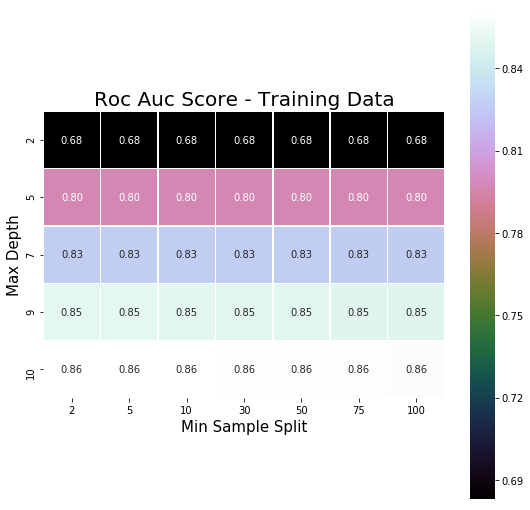

In [55]:
displayhmap = drawgraphs()

pivot_tbl = dtree.dtre_hmap_train.pivot(index='mxdpth',columns='minsmpsplit',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','Min Sample Split','Max Depth')

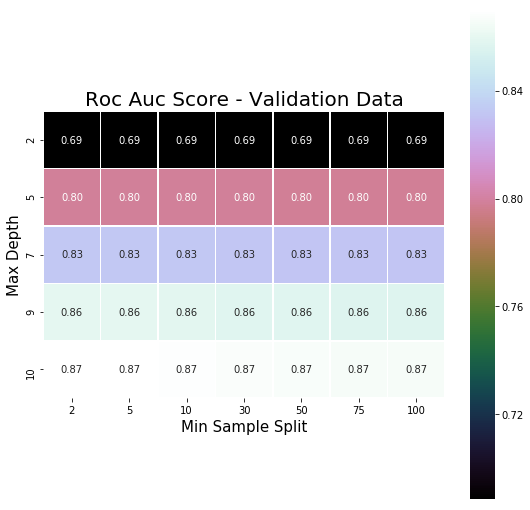

In [56]:
pivot_tbl = dtree.dtre_hmap_val.pivot(index='mxdpth',columns='minsmpsplit',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Validation Data','Min Sample Split','Max Depth')

#### Process the actual classifier  using a DTree that has no class weights ####
##### the dataset has been balanced using SMOTE #####

***X_test predict [1 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.75      0.93      0.83     14719
           1       0.91      0.68      0.78     14719

   micro avg       0.81      0.81      0.81     29438
   macro avg       0.83      0.81      0.80     29438
weighted avg       0.83      0.81      0.80     29438

*** predict probabilities*** [0.67731964 0.01440124 0.11051559 ... 0.01831303 0.01831303 0.01831303]


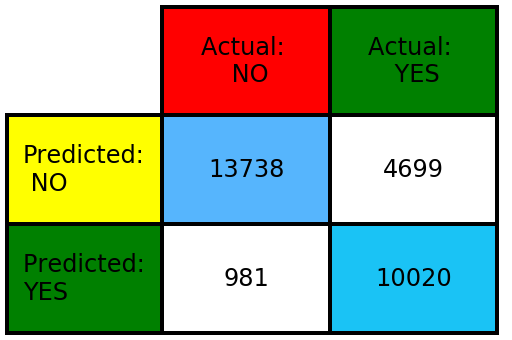

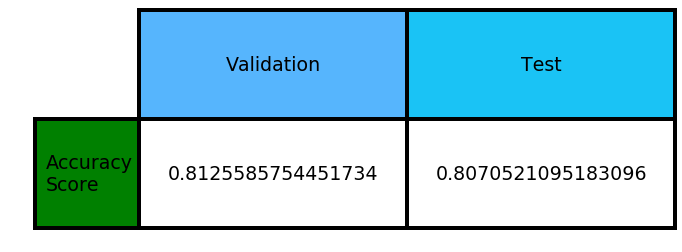

In [4]:
dtree_clf = dtree.DTreClasifierwNoWts()
dtree.DTRE_actClasifier(50,150)
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[dtree.confsnmtxytstpred['tn'] ,dtree.confsnmtxytstpred['fn']],[dtree.confsnmtxytstpred['fp'],dtree.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[dtree.accuracy_score_val,dtree.accuracy_score_test]]
displaygraph.draw_accscore(data1)
#tree.export_graphviz(dtree.getDTreClasifier(),feature_names=dtree.feat_names,class_names=dtree.y_test,\  
#                    filled=True, rounded=True,,out_file='D:/Graphviz2.38/bin/tree_bow_1.dot')  

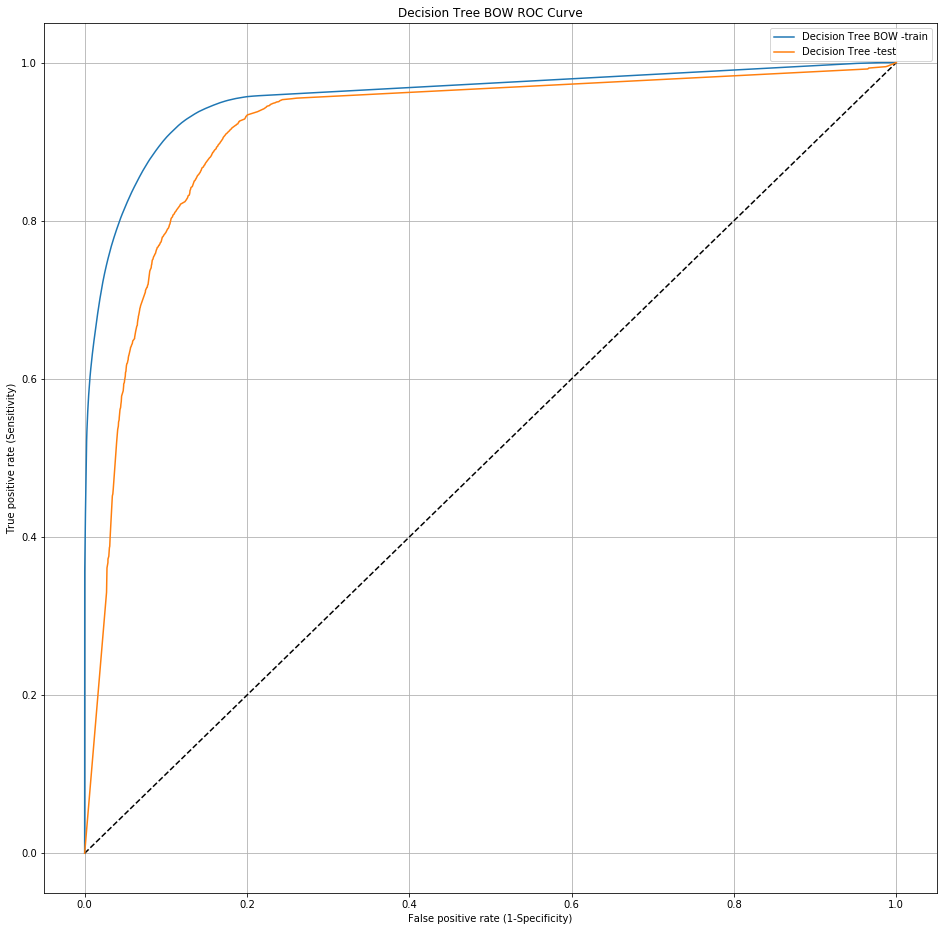

In [5]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Decision Tree BOW ROC Curve'
displaygraph.legnd_1 = 'Decision Tree BOW -train'
displaygraph.legnd_2 = 'Decision Tree -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(dtree.roc_curve_test['fpr_trn'],dtree.roc_curve_test['tpr_trn'],\
                            dtree.roc_curve_test['fpr'],dtree.roc_curve_test['tpr'])

#### Process the actual classifier  using a DTree that has no class weights ####
##### Using grid searchcv parameter tuned for Precision #####

***X_test predict [1 1 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.77      0.92      0.84     14719
           1       0.90      0.72      0.80     14719

   micro avg       0.82      0.82      0.82     29438
   macro avg       0.84      0.82      0.82     29438
weighted avg       0.84      0.82      0.82     29438

*** predict probabilities*** [0.64772937 0.51497728 0.32003241 ... 0.03304088 0.06980724 0.03304088]


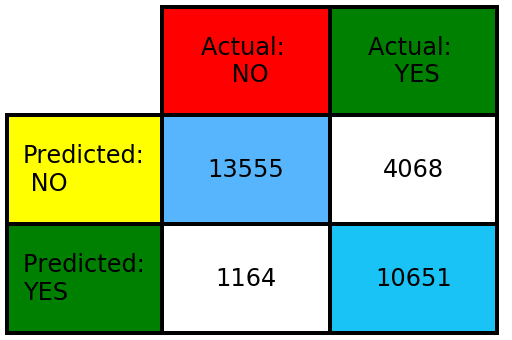

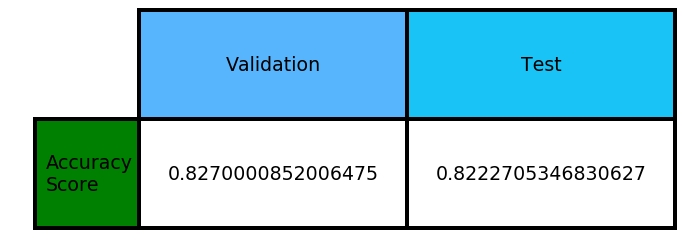

In [25]:
dtree_clf = dtree.DTreClasifierwNoWts()
dtree.DTRE_actClasifier(20,5)
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[dtree.confsnmtxytstpred['tn'] ,dtree.confsnmtxytstpred['fn']],[dtree.confsnmtxytstpred['fp'],dtree.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[dtree.accuracy_score_val,dtree.accuracy_score_test]]
displaygraph.draw_accscore(data1)

#### Process the actual classifier  using a DTree that has no class weights ####
##### Using grid searchcv parameter tuned for Recall #####

***X_test predict [1 1 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.76      0.93      0.84     14719
           1       0.91      0.71      0.80     14719

   micro avg       0.82      0.82      0.82     29438
   macro avg       0.83      0.82      0.82     29438
weighted avg       0.83      0.82      0.82     29438

*** predict probabilities*** [0.68230136 0.5448435  0.3015452  ... 0.02995115 0.06658594 0.02995115]


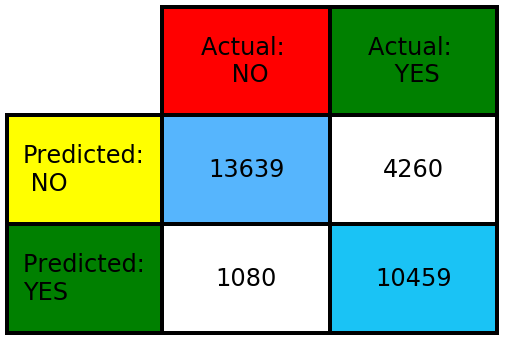

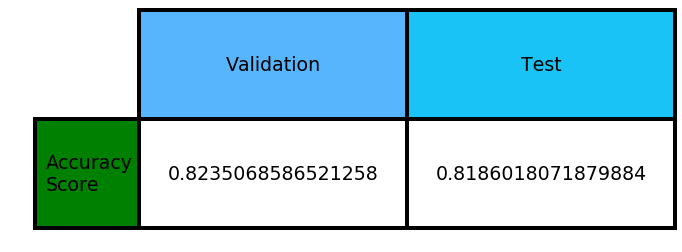

In [26]:
dtree_clf = dtree.DTreClasifierwNoWts()
dtree.DTRE_actClasifier(20,100)
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[dtree.confsnmtxytstpred['tn'] ,dtree.confsnmtxytstpred['fn']],[dtree.confsnmtxytstpred['fp'],dtree.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[dtree.accuracy_score_val,dtree.accuracy_score_test]]
displaygraph.draw_accscore(data1)

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

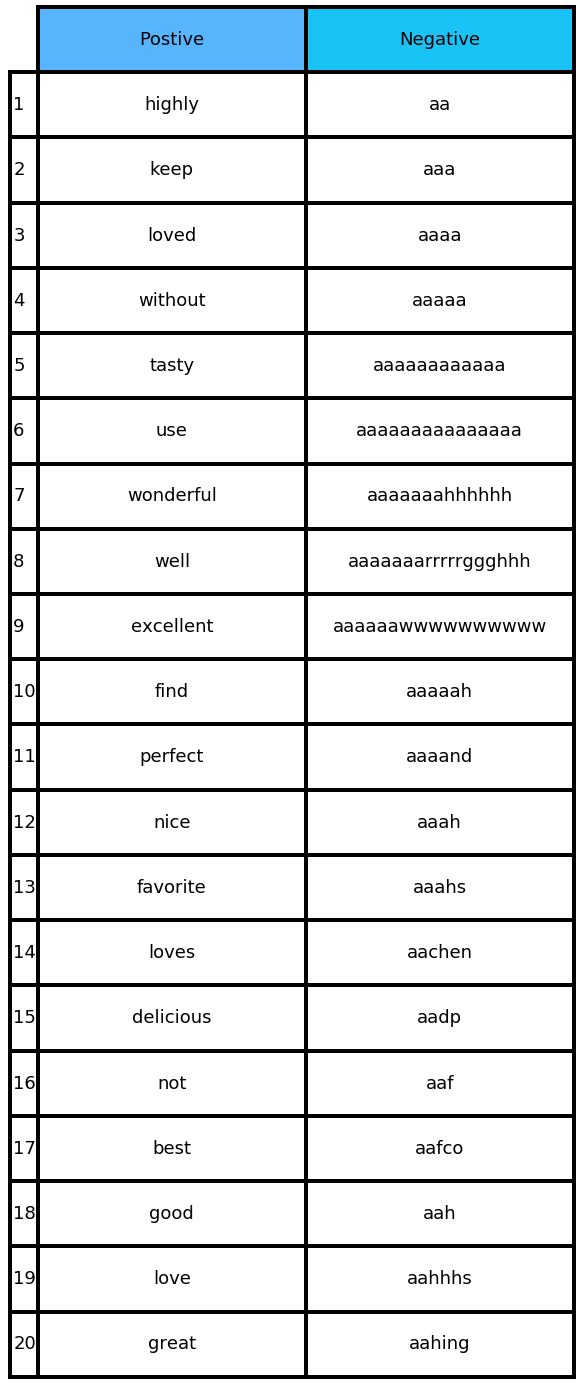

In [63]:
dtree_clf = dtree.getDTreClasifier()
feature_names = dtree.feat_names
top10_negve = sorted(zip(dtree_clf.feature_importances_, feature_names))[-20:]
top10_posve = sorted(zip(dtree_clf.feature_importances_, feature_names))[:20]
feat_pos=[]
feat_neg=[]
features=[]
for coef,feat in (top10_negve):    
    feat_pos.append(feat)
    
for cef,feat in (top10_posve):   
    feat_neg.append(feat)
    
i=0
while i< int(len(feat_pos)):
    feat_item=[]
    feat_item.append(feat_pos[i])
    feat_item.append(feat_neg[i])
    features.append(feat_item)
    i +=1
    
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.draw_posnegwords(features,20)

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [76]:
# Please write all the code with proper documentation

In [18]:
#the tree is exported  when the actual classifier process the data. this is just a place holder
#tree.export_graphviz(dtree.getDTreClasifier(),feature_names=dtree.feat_names,out_file='D:/Graphviz2.38/bin/tree_bow_1.dot   
tgt_names = []
for tgtlbl in dtree.y_test:
    
    if tgtlbl==0:
        tgt_names.append('pos')
    else:
        tgt_names.append('neg')
    
tree.export_graphviz(dtree.getDTreClasifier(),max_depth=3,feature_names=dtree.feat_names,class_names=tgt_names,filled=True,rounded=True,out_file='D:/Graphviz2.38/bin/tree_bow_23.dot')  

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [7]:
dtree_tidf = assign8DTree()
dtree_tidf.load_data('TFIDFBAL')

X_train shape (117746, 500)
y_train shape (117746,)
X_test shape (29438, 500)
y_test shape (29438,)


dtree_tidf_clf = dtree_tidf.DTreClasifierwNoWts()
dtree_tidf.dtre_calcrocaucscore()

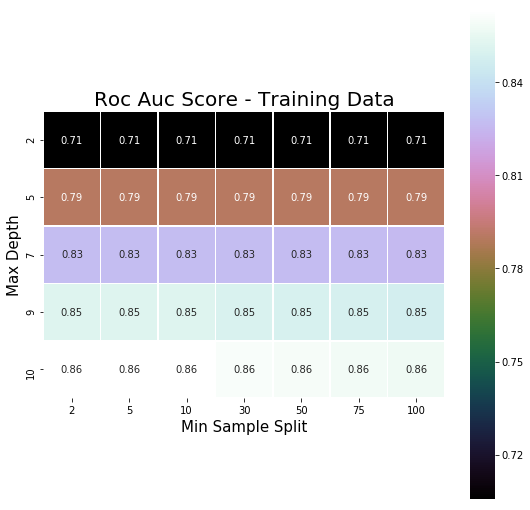

In [60]:
displayhmap1 = drawgraphs()

pivot_tbl = dtree_tidf.dtre_hmap_train.pivot(index='mxdpth',columns='minsmpsplit',values='rocaucscore').head()
displayhmap1.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','Min Sample Split','Max Depth')

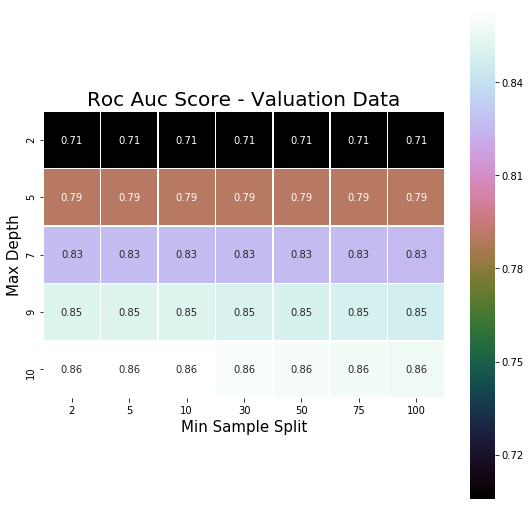

In [61]:
displayhmap2 = drawgraphs()

pivot_tbl = dtree_tidf.dtre_hmap_train.pivot(index='mxdpth',columns='minsmpsplit',values='rocaucscore').head()
displayhmap2.draw_heatmap(pivot_tbl,'Roc Auc Score - Valuation Data','Min Sample Split','Max Depth')

#### Process the actual classifier  using a DTree that has no class weights ####
##### the dataset has been balanced using SMOTE #####

In [8]:
dtree_tidf_clf = dtree_tidf.DTreClasifierwNoWts()
dtree_tidf.DTRE_actClasifier(50,250)

***X_test predict [1 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.66      0.92      0.77     14719
           1       0.86      0.52      0.65     14719

   micro avg       0.72      0.72      0.72     29438
   macro avg       0.76      0.72      0.71     29438
weighted avg       0.76      0.72      0.71     29438

*** predict probabilities*** [0.56731157 0.0225144  0.39561264 ... 0.46672894 0.02716899 0.0225144 ]


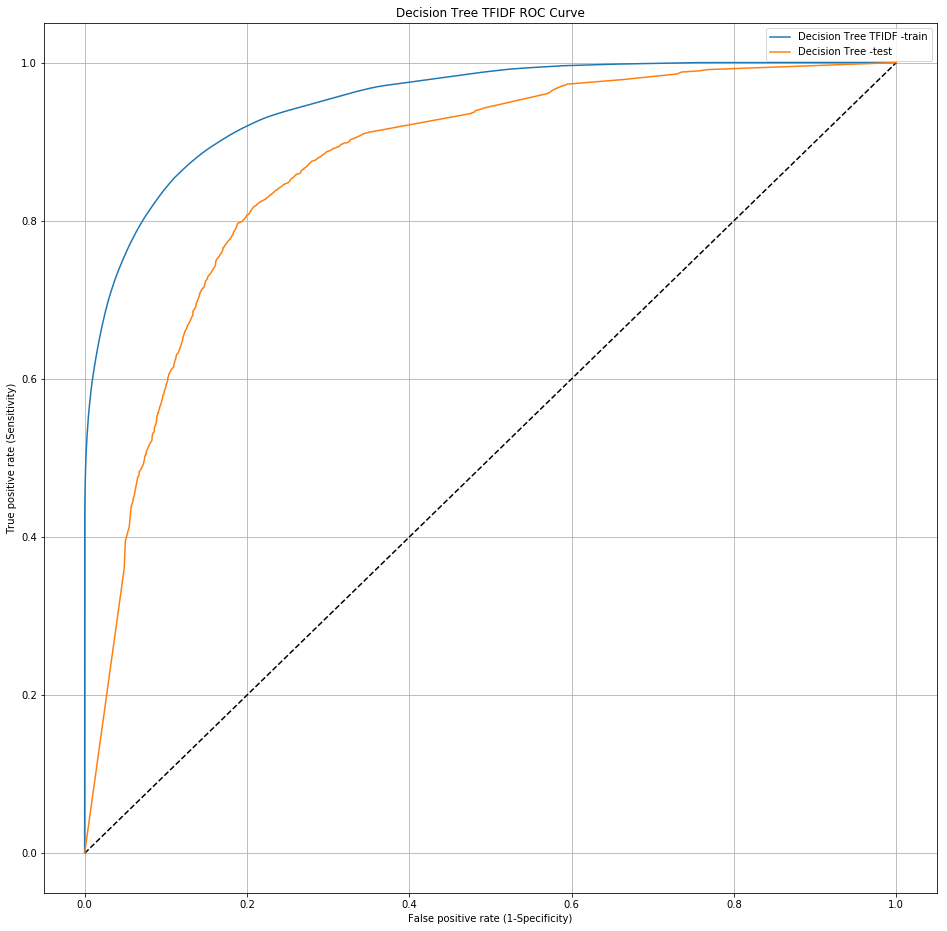

In [9]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Decision Tree TFIDF ROC Curve'
displaygraph.legnd_1 = 'Decision Tree TFIDF -train'
displaygraph.legnd_2 = 'Decision Tree -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(dtree_tidf.roc_curve_test['fpr_trn'],dtree_tidf.roc_curve_test['tpr_trn'],\
                            dtree_tidf.roc_curve_test['fpr'],dtree_tidf.roc_curve_test['tpr'])

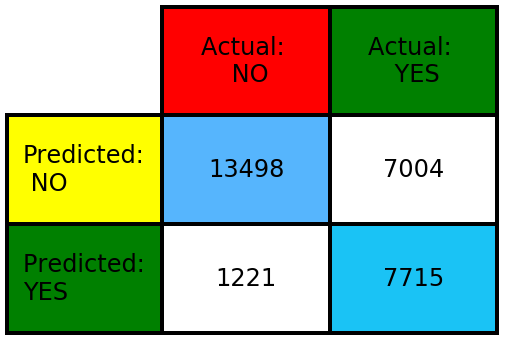

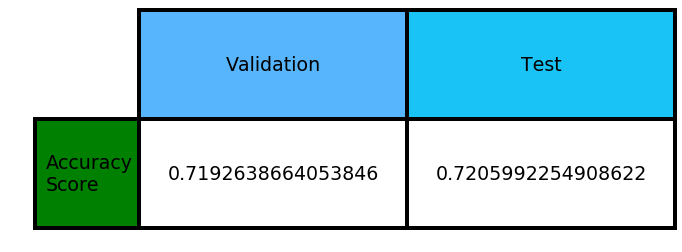

In [10]:
displaygraph_1 = drawgraphs()
data = [[dtree_tidf.confsnmtxytstpred['tn'] ,dtree_tidf.confsnmtxytstpred['fn']],[dtree_tidf.confsnmtxytstpred['fp'],dtree_tidf.confsnmtxytstpred['tp']]]
displaygraph_1.draw_table(data)
displaygraph_2 = drawgraphs()
data1= [[dtree_tidf.accuracy_score_val,dtree_tidf.accuracy_score_test]]
displaygraph_2.draw_accscore(data1)

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [85]:
# Please write all the code with proper documentation

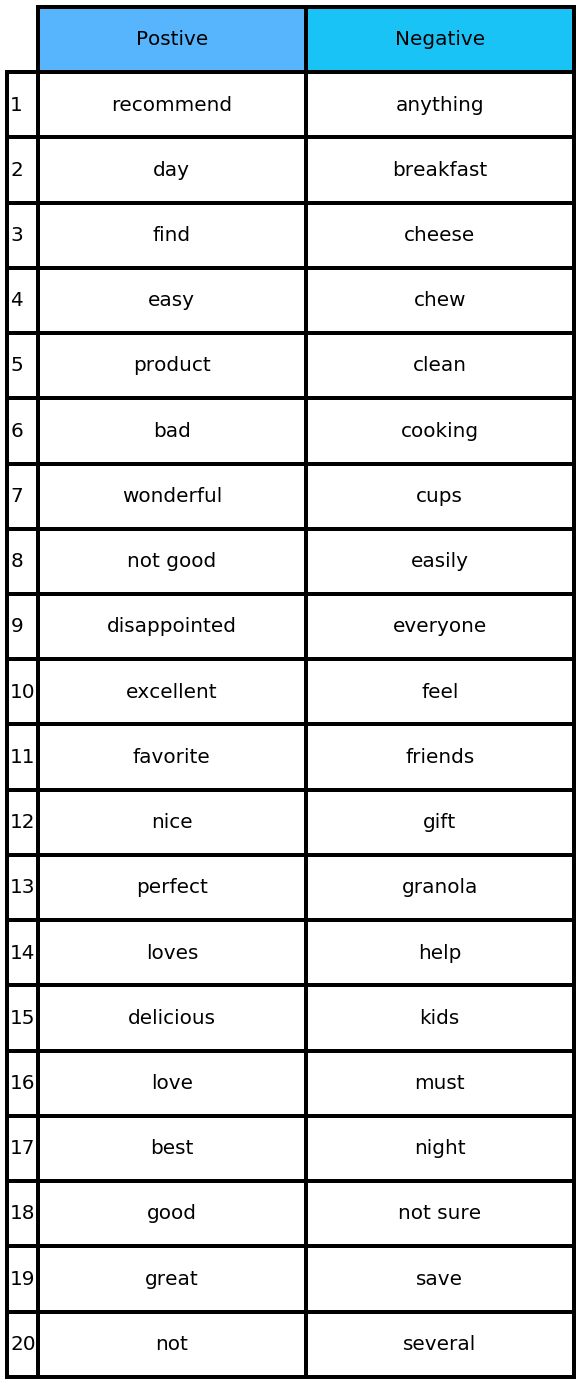

In [10]:
dtretidf_clf = dtree_tidf.getDTreClasifier()
feature_names = dtree_tidf.feat_names
top_negve = sorted(zip(dtretidf_clf.feature_importances_, feature_names))[-20:]
top_posve = sorted(zip(dtretidf_clf.feature_importances_, feature_names))[:20]
feat_pos=[]
feat_neg=[]
features=[]
for coef,feat in (top_negve):    
    feat_pos.append(feat)
    
for cef,feat in (top_posve):   
    feat_neg.append(feat)
    
i=0
while i< int(len(feat_pos)):
    feat_item=[]
    feat_item.append(feat_pos[i])
    feat_item.append(feat_neg[i])
    features.append(feat_item)
    i +=1
    
dgrph_tidf = drawgraphs()
dgrph_tidf.setdefaultparm()
dgrph_tidf.draw_posnegwords(features,20)

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>###

In [0]:
# Please write all the code with proper documentation

In [19]:
tgt_names = []
for tgtlbl in dtree_tidf.y_test:    
    if tgtlbl==0:
        tgt_names.append('pos')
    else:
        tgt_names.append('neg')
tree.export_graphviz(dtree_tidf.getDTreClasifier(),max_depth=3,feature_names=dtree_tidf.feat_names,filled=True,rounded=True,out_file='D:/Graphviz2.38/bin/tree_tfidf_4.dot') 

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

<font color='red'> Remarks </font>
<font color='blue'>
For the above two vectorizers (BOW) and (TFIDF) we used a balanced dataset that we crated
using SMOTE. When the same dataset was used for AVGW2V and TFIDFWTW2V the positive class never got predicted.
Hence for AVGW2V and TFIDF we will be changing our strategy and using the dataset that contains the imbalance.
We will handle the imbalance by using CLASS WEIGHTS parameter in the base estimator and also the SAMPLE_WEIGHT
parameter in the FIT() method of the base estimator. 

By combining these two parameters we can derive four different models. The model with both the class and sample
weights need not considered whereas the other three models are significant.</font>

In [108]:
# Please write all the code with proper documentation

In [26]:
dtree_avgw2v = assign8DTree()
dtree_avgw2v.load_data('AVGW2V')

X_train shape (70218, 50)
y_train shape (70218,)
X_test shape (17555, 50)
y_test shape (17555,)


In [ ]:
dtree_avgw2v_clf = dtree_avgw2v.DTreClasifierwNoWts()
dtree_avgw2v.dtre_calcrocaucscore()

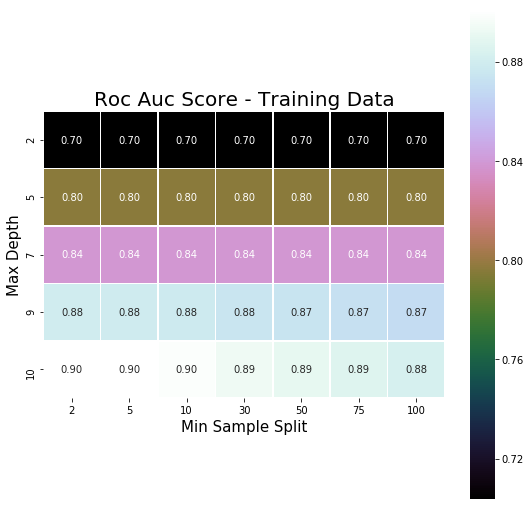

In [63]:
displayhmap1 = drawgraphs()

pivot_tbl = dtree_avgw2v.dtre_hmap_train.pivot(index='mxdpth',columns='minsmpsplit',values='rocaucscore').head()
displayhmap1.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','Min Sample Split','Max Depth')

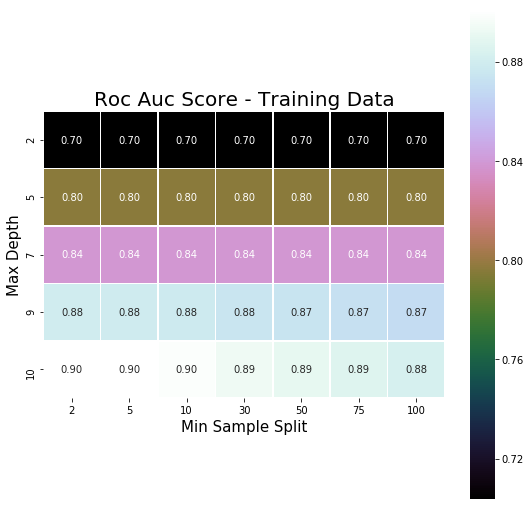

In [64]:
displayhmap2 = drawgraphs()

pivot_tbl = dtree_avgw2v.dtre_hmap_train.pivot(index='mxdpth',columns='minsmpsplit',values='rocaucscore').head()
displayhmap2.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','Min Sample Split','Max Depth')

#### Using DTree with no class weights on Imbalanced datasets####

***X_test predict [1 0 1 ... 0 1 1]
              precision    recall  f1-score   support

           0       0.28      0.44      0.34      2836
           1       0.88      0.78      0.83     14719

   micro avg       0.73      0.73      0.73     17555
   macro avg       0.58      0.61      0.58     17555
weighted avg       0.78      0.73      0.75     17555

*** predict probabilities*** [0.55101682 0.36280109 0.60269674 ... 0.10445056 0.60269674 0.61588299]


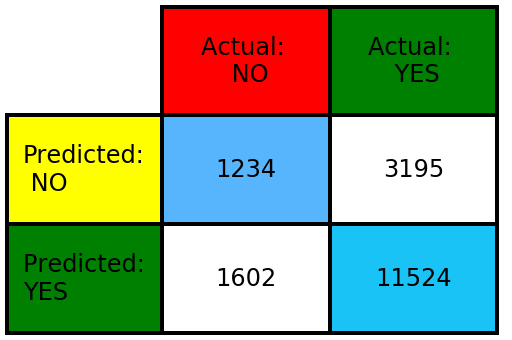

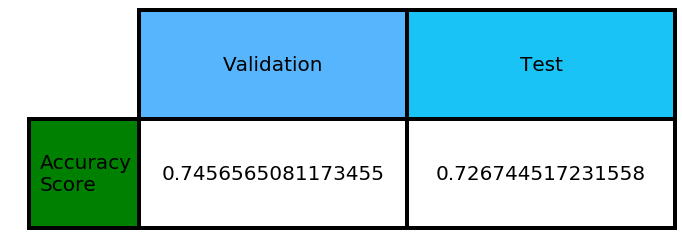

In [27]:
#gridsearchcv value producing not so good results
dtree_avgw2v_clf = dtree_avgw2v.DTreClasifierwNoWts()
dtree_avgw2v.DTRE_actClasifier(9,250)
#dtree_avgw2v.DTRE_actClasifier(10,50)
displaygraph_1 = drawgraphs()
data = [[dtree_avgw2v.confsnmtxytstpred['tn'] ,dtree_avgw2v.confsnmtxytstpred['fn']],[dtree_avgw2v.confsnmtxytstpred['fp'],dtree_avgw2v.confsnmtxytstpred['tp']]]
displaygraph_1.draw_table(data)
displaygraph_2 = drawgraphs()
data1= [[dtree_avgw2v.accuracy_score_val,dtree_avgw2v.accuracy_score_test]]
displaygraph_2.draw_accscore(data1)

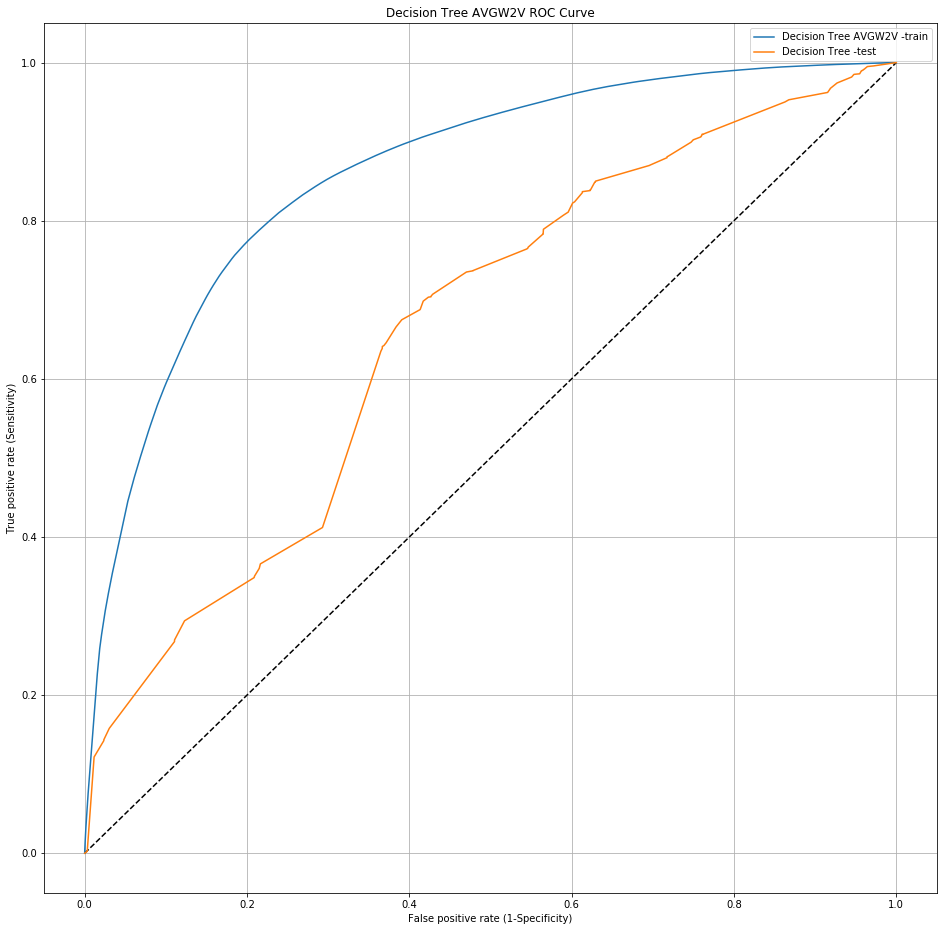

In [31]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Decision Tree AVGW2V ROC Curve'
displaygraph.legnd_1 = 'Decision Tree AVGW2V -train'
displaygraph.legnd_2 = 'Decision Tree -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(dtree_avgw2v.roc_curve_test['fpr_trn'],dtree_avgw2v.roc_curve_test['tpr_trn'],\
                            dtree_avgw2v.roc_curve_test['fpr'],dtree_avgw2v.roc_curve_test['tpr'])

#### Using DTree with no class weights and fit having sample weights on Imbalanced datasets####

***X_test predict [1 0 1 ... 0 1 1]
              precision    recall  f1-score   support

           0       0.27      0.63      0.38      2836
           1       0.90      0.68      0.77     14719

   micro avg       0.67      0.67      0.67     17555
   macro avg       0.59      0.65      0.58     17555
weighted avg       0.80      0.67      0.71     17555

*** predict probabilities*** [0.54322914 0.36540801 0.62359925 ... 0.26505111 0.64759787 0.68783247]


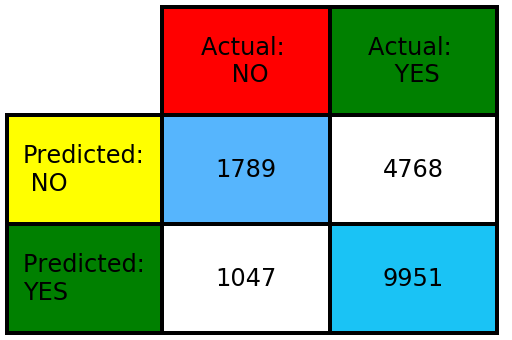

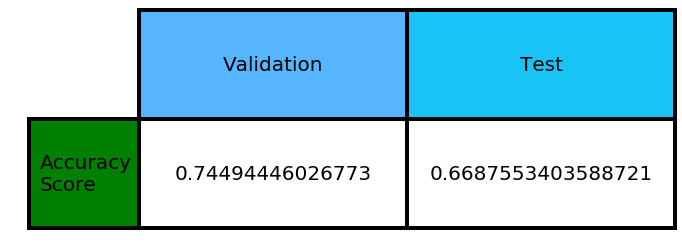

In [29]:
dtree_avgw2v_clf = dtree_avgw2v.DTreClasifierwNoWts()
dtree_avgw2v.DTRE_actClasifier(9,250,True)
#dtree_avgw2v.DTRE_actClasifier(10,50)
displaygraph_1 = drawgraphs()
data = [[dtree_avgw2v.confsnmtxytstpred['tn'] ,dtree_avgw2v.confsnmtxytstpred['fn']],[dtree_avgw2v.confsnmtxytstpred['fp'],dtree_avgw2v.confsnmtxytstpred['tp']]]
displaygraph_1.draw_table(data)
displaygraph_2 = drawgraphs()
data1= [[dtree_avgw2v.accuracy_score_val,dtree_avgw2v.accuracy_score_test]]
displaygraph_2.draw_accscore(data1)

#### Using DTree with class weights on Imbalanced datasets####

***X_test predict [1 0 1 ... 0 1 1]
              precision    recall  f1-score   support

           0       0.28      0.44      0.34      2836
           1       0.88      0.78      0.83     14719

   micro avg       0.73      0.73      0.73     17555
   macro avg       0.58      0.61      0.58     17555
weighted avg       0.78      0.73      0.75     17555

*** predict probabilities*** [0.55101682 0.36280109 0.60269674 ... 0.10445056 0.60269674 0.61588299]


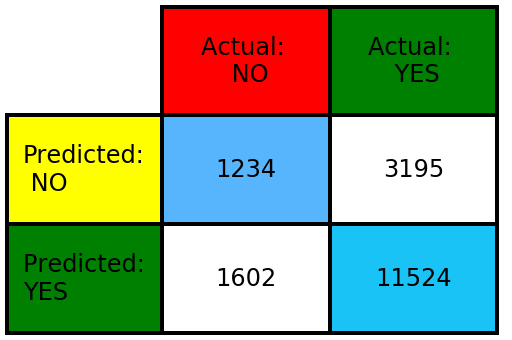

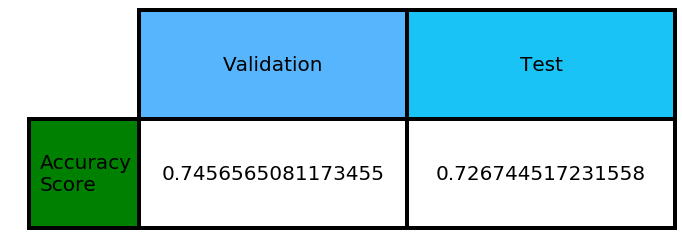

In [30]:
#non gridsearchcv value producing better results
dtree_avgw2v_clf = dtree_avgw2v.DTreClasifier()
dtree_avgw2v.DTRE_actClasifier(9,250)
displaygraph_1 = drawgraphs()
data = [[dtree_avgw2v.confsnmtxytstpred['tn'] ,dtree_avgw2v.confsnmtxytstpred['fn']],[dtree_avgw2v.confsnmtxytstpred['fp'],dtree_avgw2v.confsnmtxytstpred['tp']]]
displaygraph_1.draw_table(data)
displaygraph_2 = drawgraphs()
data1= [[dtree_avgw2v.accuracy_score_val,dtree_avgw2v.accuracy_score_test]]
displaygraph_2.draw_accscore(data1)

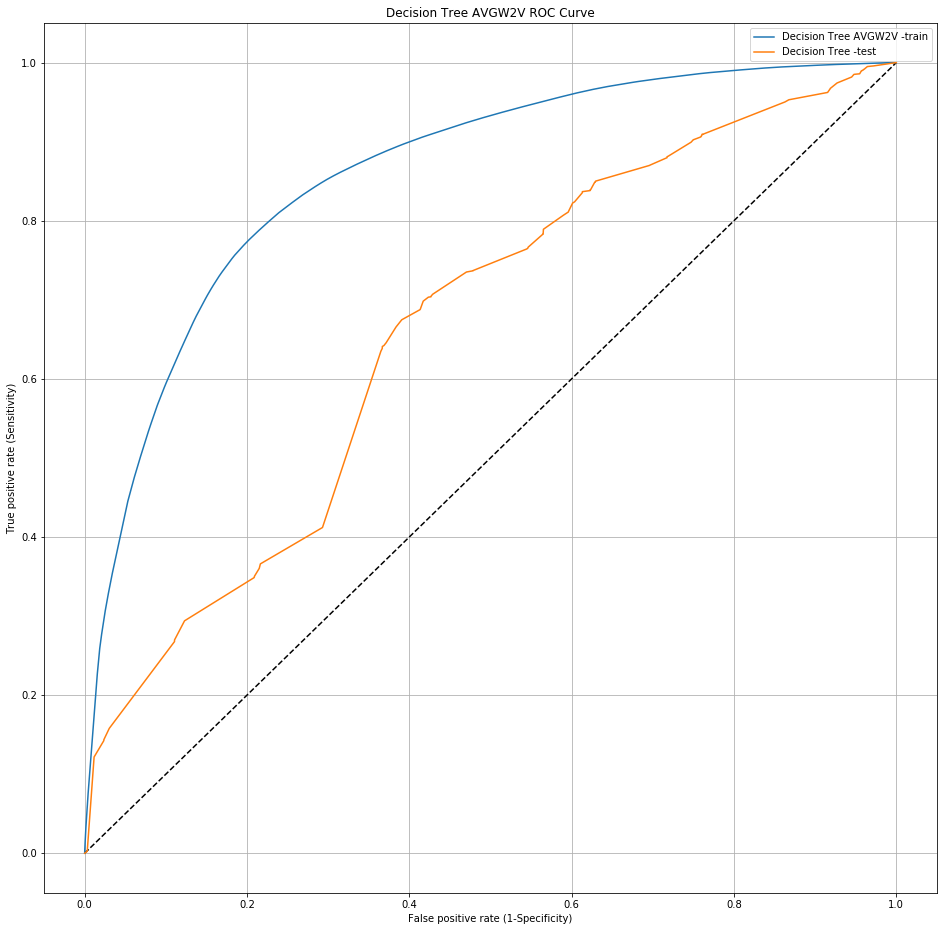

In [32]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Decision Tree AVGW2V ROC Curve'
displaygraph.legnd_1 = 'Decision Tree AVGW2V -train'
displaygraph.legnd_2 = 'Decision Tree -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(dtree_avgw2v.roc_curve_test['fpr_trn'],dtree_avgw2v.roc_curve_test['tpr_trn'],\
                            dtree_avgw2v.roc_curve_test['fpr'],dtree_avgw2v.roc_curve_test['tpr'])

#### Using DTree with class weights and fit having sample weights on Imbalanced datasets####

***X_test predict [1 0 1 ... 0 1 1]
              precision    recall  f1-score   support

           0       0.27      0.63      0.38      2836
           1       0.90      0.68      0.77     14719

   micro avg       0.67      0.67      0.67     17555
   macro avg       0.59      0.65      0.58     17555
weighted avg       0.80      0.67      0.71     17555

*** predict probabilities*** [0.54322914 0.36540801 0.62359925 ... 0.26505111 0.64759787 0.68783247]


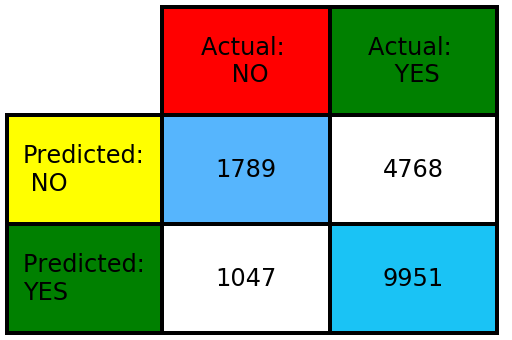

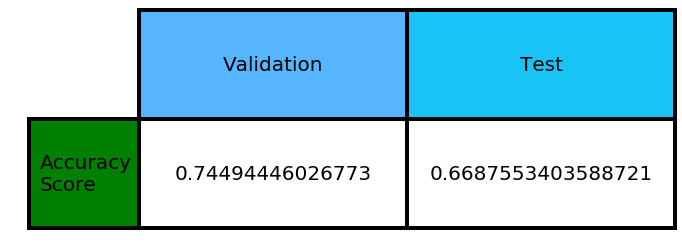

In [51]:
#non gridsearchcv value producing better results
dtree_avgw2v_clf = dtree_avgw2v.DTreClasifier()
dtree_avgw2v.DTRE_actClasifier(9,250,True)
displaygraph_1 = drawgraphs()
data = [[dtree_avgw2v.confsnmtxytstpred['tn'] ,dtree_avgw2v.confsnmtxytstpred['fn']],[dtree_avgw2v.confsnmtxytstpred['fp'],dtree_avgw2v.confsnmtxytstpred['tp']]]
displaygraph_1.draw_table(data)
displaygraph_2 = drawgraphs()
data1= [[dtree_avgw2v.accuracy_score_val,dtree_avgw2v.accuracy_score_test]]
displaygraph_2.draw_accscore(data1)

### [5.3.1] Graphviz visualization of Decision Tree on AVG W2V,<font color='red'> SET 3</font>

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [34]:
dtree_wtw2v = assign8DTree()
dtree_wtw2v.load_data('WTW2V')

X_train shape (70218, 50)
y_train shape (70218,)
X_test shape (17555, 50)
y_test shape (17555,)


dtree_wtw2v_clf = dtree_wtw2v.DTreClasifierwNoWts()
dtree_wtw2v.dtre_calcrocaucscore()

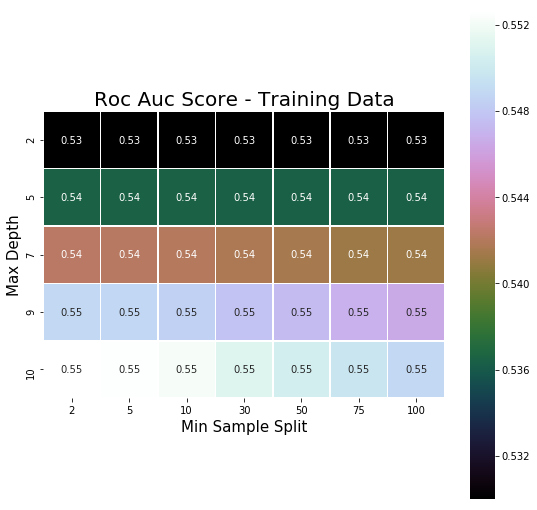

In [67]:
displayhmap1 = drawgraphs()

pivot_tbl = dtree_wtw2v.dtre_hmap_train.pivot(index='mxdpth',columns='minsmpsplit',values='rocaucscore').head()
displayhmap1.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','Min Sample Split','Max Depth')

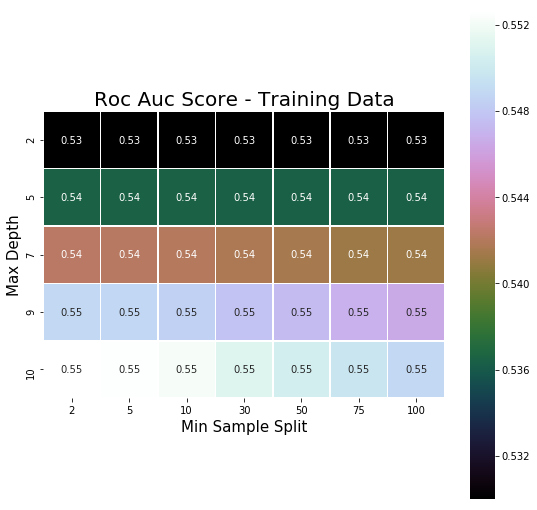

In [68]:
displayhmap2 = drawgraphs()

pivot_tbl = dtree_wtw2v.dtre_hmap_train.pivot(index='mxdpth',columns='minsmpsplit',values='rocaucscore').head()
displayhmap2.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','Min Sample Split','Max Depth')

#### Using DTree with no class weights on Imbalanced datasets####

***X_test predict [1 1 1 ... 1 1 0]
              precision    recall  f1-score   support

           0       0.16      0.08      0.11      2836
           1       0.84      0.92      0.88     14719

   micro avg       0.78      0.78      0.78     17555
   macro avg       0.50      0.50      0.49     17555
weighted avg       0.73      0.78      0.75     17555

*** predict probabilities*** [0.50098095 0.50098095 0.50235526 ... 0.50098095 0.50098095 0.48925243]


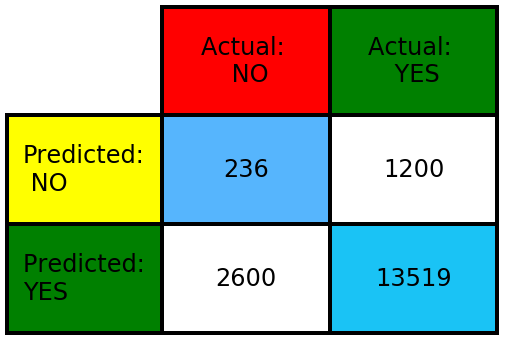

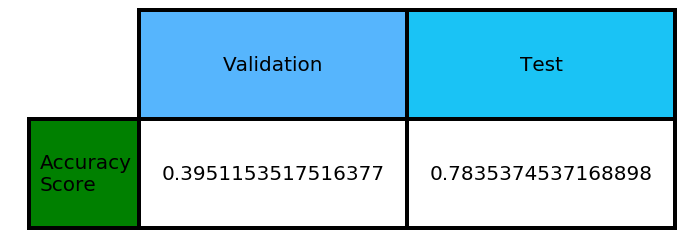

In [35]:
dtree_wtw2v_clf = dtree_wtw2v.DTreClasifierwNoWts()
dtree_wtw2v.DTRE_actClasifier(7,200,False)
displaygraph_1 = drawgraphs()
data = [[dtree_wtw2v.confsnmtxytstpred['tn'] ,dtree_wtw2v.confsnmtxytstpred['fn']],[dtree_wtw2v.confsnmtxytstpred['fp'],dtree_wtw2v.confsnmtxytstpred['tp']]]
displaygraph_1.draw_table(data)
displaygraph_2 = drawgraphs()
data1= [[dtree_wtw2v.accuracy_score_val,dtree_wtw2v.accuracy_score_test]]
displaygraph_2.draw_accscore(data1)

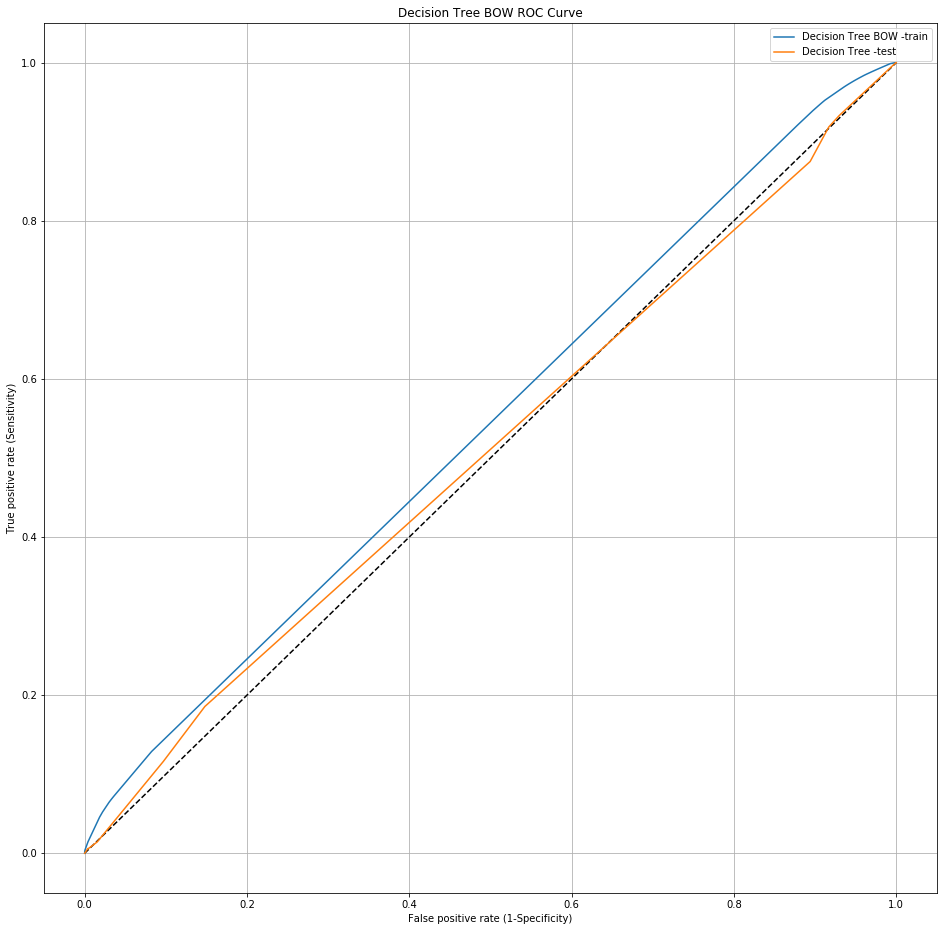

In [36]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Decision Tree BOW ROC Curve'
displaygraph.legnd_1 = 'Decision Tree BOW -train'
displaygraph.legnd_2 = 'Decision Tree -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(dtree_wtw2v.roc_curve_test['fpr_trn'],dtree_wtw2v.roc_curve_test['tpr_trn'],\
                            dtree_wtw2v.roc_curve_test['fpr'],dtree_wtw2v.roc_curve_test['tpr'])

#### Using DTree with no class weights and fit having sample weights on Imbalanced datasets####

***X_test predict [0 0 1 ... 0 0 1]
              precision    recall  f1-score   support

           0       0.17      0.79      0.28      2836
           1       0.86      0.25      0.39     14719

   micro avg       0.34      0.34      0.34     17555
   macro avg       0.51      0.52      0.33     17555
weighted avg       0.75      0.34      0.37     17555

*** predict probabilities*** [0.49970506 0.4866651  0.50080049 ... 0.49970506 0.47545538 0.56336677]


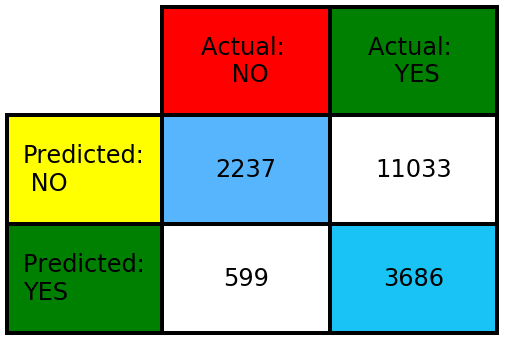

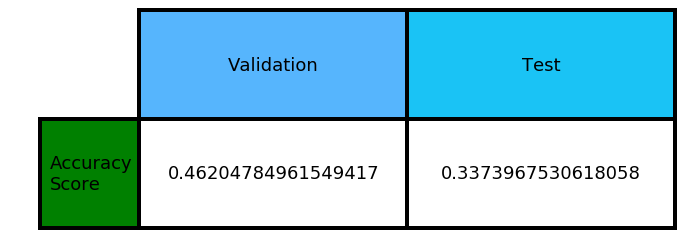

In [47]:
dtree_wtw2v_clf = dtree_wtw2v.DTreClasifierwNoWts()
dtree_wtw2v.DTRE_actClasifier(7,200,True)
displaygraph_1 = drawgraphs()
data = [[dtree_wtw2v.confsnmtxytstpred['tn'] ,dtree_wtw2v.confsnmtxytstpred['fn']],[dtree_wtw2v.confsnmtxytstpred['fp'],dtree_wtw2v.confsnmtxytstpred['tp']]]
displaygraph_1.draw_table(data)
displaygraph_2 = drawgraphs()
data1= [[dtree_wtw2v.accuracy_score_val,dtree_wtw2v.accuracy_score_test]]
displaygraph_2.draw_accscore(data1)

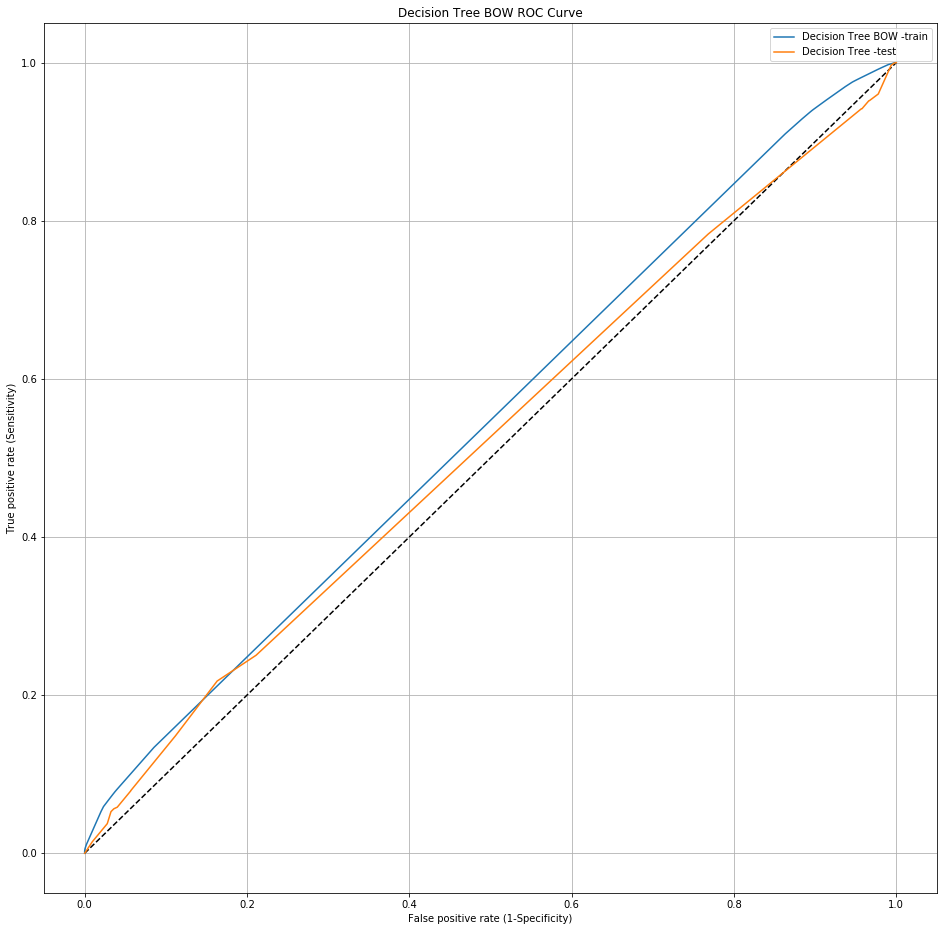

In [48]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Decision Tree BOW ROC Curve'
displaygraph.legnd_1 = 'Decision Tree BOW -train'
displaygraph.legnd_2 = 'Decision Tree -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(dtree_wtw2v.roc_curve_test['fpr_trn'],dtree_wtw2v.roc_curve_test['tpr_trn'],\
                            dtree_wtw2v.roc_curve_test['fpr'],dtree_wtw2v.roc_curve_test['tpr'])

#### Using DTree with class weights on Imbalanced datasets####

***X_test predict [0 0 0 ... 0 0 1]
              precision    recall  f1-score   support

           0       0.16      0.87      0.28      2836
           1       0.85      0.15      0.26     14719

   micro avg       0.27      0.27      0.27     17555
   macro avg       0.51      0.51      0.27     17555
weighted avg       0.74      0.27      0.26     17555

*** predict probabilities*** [0.4968742  0.49807826 0.49599793 ... 0.4968742  0.4968742  0.54103341]


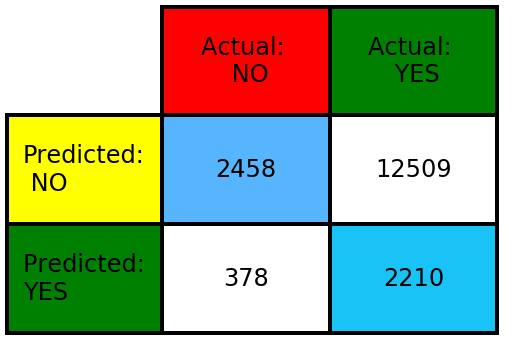

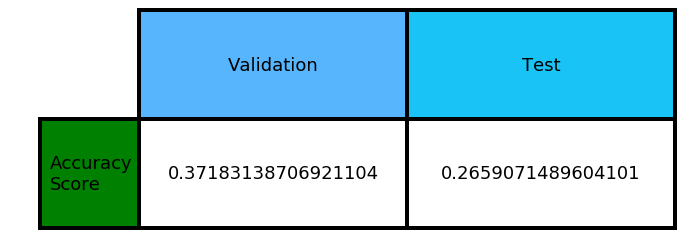

In [49]:
dtree_wtw2v_clf = dtree_wtw2v.DTreClasifier()
dtree_wtw2v.DTRE_actClasifier(9,230,False)
displaygraph_1 = drawgraphs()
data = [[dtree_wtw2v.confsnmtxytstpred['tn'] ,dtree_wtw2v.confsnmtxytstpred['fn']],[dtree_wtw2v.confsnmtxytstpred['fp'],dtree_wtw2v.confsnmtxytstpred['tp']]]
displaygraph_1.draw_table(data)
displaygraph_2 = drawgraphs()
data1= [[dtree_wtw2v.accuracy_score_val,dtree_wtw2v.accuracy_score_test]]
displaygraph_2.draw_accscore(data1)

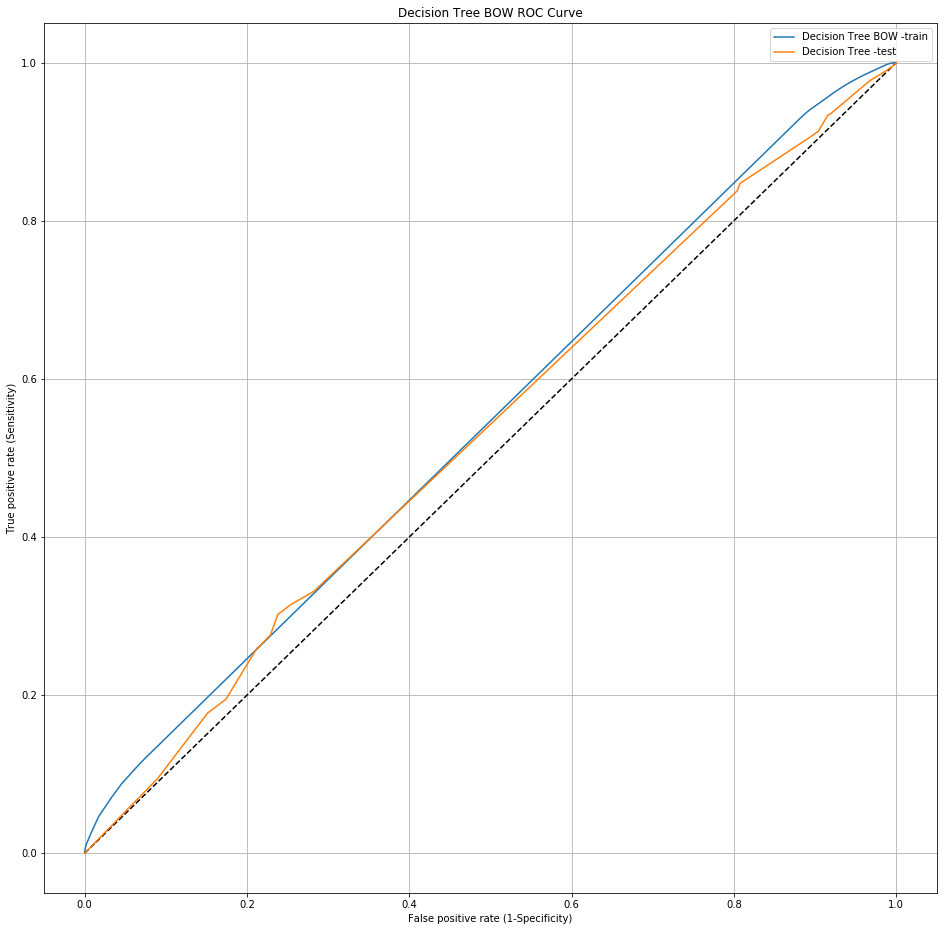

In [43]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Decision Tree BOW ROC Curve'
displaygraph.legnd_1 = 'Decision Tree BOW -train'
displaygraph.legnd_2 = 'Decision Tree -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(dtree_wtw2v.roc_curve_test['fpr_trn'],dtree_wtw2v.roc_curve_test['tpr_trn'],\
                            dtree_wtw2v.roc_curve_test['fpr'],dtree_wtw2v.roc_curve_test['tpr'])

#### Using DTree with class weights and fit having sample weights  on imbalance datasets ####

***X_test predict [1 0 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.17      0.22      0.19      2836
           1       0.84      0.79      0.81     14719

   micro avg       0.70      0.70      0.70     17555
   macro avg       0.50      0.51      0.50     17555
weighted avg       0.73      0.70      0.71     17555

*** predict probabilities*** [0.50004464 0.49214741 0.50045721 ... 0.50004464 0.51257679 0.55062397]


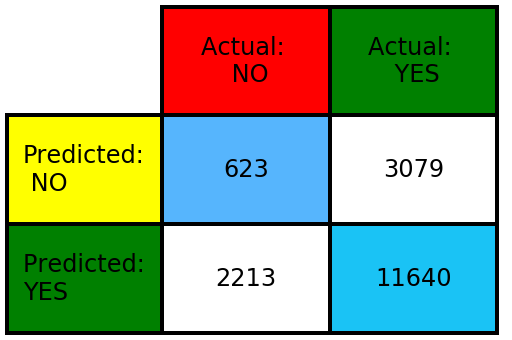

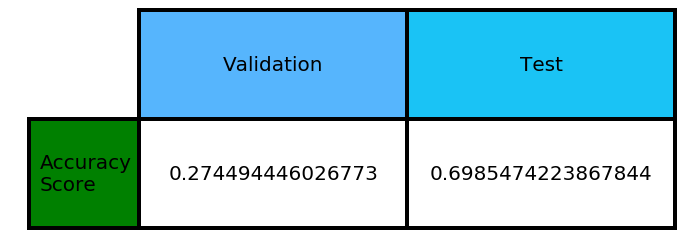

In [50]:
dtree_wtw2v_clf = dtree_wtw2v.DTreClasifier()
dtree_wtw2v.DTRE_actClasifier(9,230,True)
displaygraph_1 = drawgraphs()
data = [[dtree_wtw2v.confsnmtxytstpred['tn'] ,dtree_wtw2v.confsnmtxytstpred['fn']],[dtree_wtw2v.confsnmtxytstpred['fp'],dtree_wtw2v.confsnmtxytstpred['tp']]]
displaygraph_1.draw_table(data)
displaygraph_2 = drawgraphs()
data1= [[dtree_wtw2v.accuracy_score_val,dtree_wtw2v.accuracy_score_test]]
displaygraph_2.draw_accscore(data1)

### [5.4.1] Graphviz visualization of Decision Tree on TFIDF W2V,<font color='red'> SET 4</font>

In [37]:
feat_names = dtree_wtw2v.feat_names[:50]
tgt_names = []
for tgtlbl in dtree_tidf.y_test:    
    if tgtlbl==0:
        tgt_names.append('pos')
    else:
        tgt_names.append('neg')
tree.export_graphviz(dtree_wtw2v.getDTreClasifier(),max_depth=3,class_names=tgt_names,feature_names=feat_names,filled=True,rounded=True,out_file='D:/Graphviz2.38/bin/tree_wtw2v_1.dot') 

# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

<font color='red'> REMARKS </font>
<font color='blue'>
1. Gridsearch Parameters. For all GridSearchCV functions that I have executed so far the values for
the parameters would be the maximum values provided in the list. In these circumstances I have added new values greater than the maximum value in the list and re-run grid search to find that, GridSearchCV returned some other value other the ones it returned earlier.
2. The results during the first submission of this assignment were not acceptable. While reviewing the code and data , I 
found that the dataset we are analyzing here is an imbalanced dataset. I have used Smote to balance the dataset. The BOW and TFIDF vectorizers performed well were as AVGW2V and TFIDFWTW2V were overfitting. Due to this in the concluding report there wil be one section for BOW and TFIDF and another section for AVGW2V and TFIDFWTW2V. For BOW/TFIDF,the base estimator will be a vanilla Decision Tree classifier with no extra options. But for the other two we will be using the CLASS weights in the Decision Tree classifier and SAMPLE weights in the FIT function of the classifier.
3. Feature Importances for BOW and TFIDF vectorizer have been included in the tree visualizations.
</font>

### [6.1] Decision Trees with imbalnced data  ###
### Used SMOTE as data balancing strategy ###
### Using splitter paramater 'best'  ###

In [38]:
import tabulate
bstgrdres_tab = [['Vectorizer', 'Max Depth','Min Sample split', 'Accuracy Score'],
         ['BOW',50,150,0.80], 
         ['TF-IDF',25,250,0.72]]
print(tabulate.tabulate(bstgrdres_tab, tablefmt='fancy_grid'))

╒════════════╤═══════════╤══════════════════╤════════════════╕
│ Vectorizer │ Max Depth │ Min Sample split │ Accuracy Score │
├────────────┼───────────┼──────────────────┼────────────────┤
│ BOW        │ 50        │ 150              │ 0.8            │
├────────────┼───────────┼──────────────────┼────────────────┤
│ TF-IDF     │ 25        │ 250              │ 0.72           │
╘════════════╧═══════════╧══════════════════╧════════════════╛


### [6.2] Decision Trees with  imbalanced data###
### Using Class/Sample weight as data balancing strategy ###
### Using splitter paramater 'best' ###

In [3]:
import tabulate
bstarbres_tab = [['Vectorizer','Classifier', 'Max Depth','Min Sample split', 'Accuracy Score'],
         ['AVGW2V','No Class Weights',9,250,0.73],  
         ['AVGW2V','No Class Weights\nFit with\nSample Weights',9,250,0.67],  
         ['AVGW2V','With Class Weights',9,250,0.73],
         ['AVGW2V','With Class and\nSample Weights',9,250,0.67],                
         ['WTW2V','No Class Weights',7,200,0.79],  
         ['WTW2V','No Class Weights\nFit with\nSample Weights',7,200,0.33],  
         ['WTW2V','With Class Weights',9,230,0.27],
         ['WTW2V','With Class and\nSample Weights',9,230,0.70]]
         
print(tabulate.tabulate(bstarbres_tab, tablefmt='fancy_grid'))

╒════════════╤════════════════════╤═══════════╤══════════════════╤════════════════╕
│ Vectorizer │ Classifier         │ Max Depth │ Min Sample split │ Accuracy Score │
├────────────┼────────────────────┼───────────┼──────────────────┼────────────────┤
│ AVGW2V     │ No Class Weights   │ 9         │ 250              │ 0.73           │
├────────────┼────────────────────┼───────────┼──────────────────┼────────────────┤
│ AVGW2V     │ No Class Weights   │ 9         │ 250              │ 0.67           │
│            │ Fit with           │           │                  │                │
│            │ Sample Weights     │           │                  │                │
├────────────┼────────────────────┼───────────┼──────────────────┼────────────────┤
│ AVGW2V     │ With Class Weights │ 9         │ 250              │ 0.73           │
├────────────┼────────────────────┼───────────┼──────────────────┼────────────────┤
│ AVGW2V     │ With Class and     │ 9         │ 250              │ 0.67     